In [20]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import math
import seaborn as sns
from scipy.stats import probplot

import warnings
warnings.filterwarnings('ignore')

# DATA PREPROCESSING

### AIRBNB DATA

In [21]:
# read the airbnb data
bcn_bnb = pd.read_csv('/Users/albapi/Desktop/uni/2n_sem/social_data/social_data_assignments/final_project/data/listings_barcelona.csv')
mad_bnb = pd.read_csv('/Users/albapi/Desktop/uni/2n_sem/social_data/social_data_assignments/final_project/data/listings_madrid.csv')
vlc_bnb = pd.read_csv('/Users/albapi/Desktop/uni/2n_sem/social_data/social_data_assignments/final_project/data/listings_valencia.csv')
mall_bnb = pd.read_csv('/Users/albapi/Desktop/uni/2n_sem/social_data/social_data_assignments/final_project/data/listings_mallorca.csv')

In [22]:
print(bcn_bnb.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca


All the columns are the same in all the files, so a common function is created to filter all the files in the same way. 

In [23]:
def filter_df(file):
    
    # keep only the columns we are interested in
    file_filt = file[['id', 'name', 'host_name', 'host_id', 'host_since', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type', 'price', 'last_review',
                        'license', 'property_type', 'host_location']]

    # rename some columns for better clarity
    file_filt.rename(columns={'neighbourhood_group_cleansed': 'district'}, inplace=True)
    file_filt.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

    # filter for last_rewview, keep only reviews of 2024 and 2025, to get the apartments that are still active
    file_filt['last_review'] = pd.to_datetime(file_filt['last_review'], errors='coerce')
    file_filt['last_review'] = file_filt['last_review'].dt.year
    file_filt = file_filt.dropna(subset=['last_review'])
    file_filt['last_review'] = file_filt['last_review'].astype(int)
    file_filt = file_filt[file_filt['last_review'] >= 2024]

    # see how many rows were removed
    num = file.shape[0] - file_filt.shape[0]
    print(f"Removed {num} rows")

    return file_filt

In [24]:
# filter the dataframes
bcn_filt_bnb = filter_df(bcn_bnb)
mad_filt_bnb = filter_df(mad_bnb)
vlc_filt_bnb = filter_df(vlc_bnb)
mall_filt_bnb = filter_df(mall_bnb)

Removed 7621 rows
Removed 8492 rows
Removed 2142 rows
Removed 6118 rows


In [25]:
# see the columns we have
print(bcn_filt_bnb.columns)

Index(['id', 'name', 'host_name', 'host_id', 'host_since', 'neighbourhood',
       'district', 'latitude', 'longitude', 'room_type', 'price',
       'last_review', 'license', 'property_type', 'host_location'],
      dtype='object')


In [26]:
# Find duplicates (excluding the first occurrence)
duplicates = bcn_filt_bnb[bcn_filt_bnb.duplicated(subset=['host_id'])]

# Print number and the actual duplicate rows
print(f"Number of duplicate rows: {duplicates.shape[0]}")
# print(duplicates)

Number of duplicate rows: 7802


In [27]:
# Count occurrences of each duplicated host_id
duplicate_counts = bcn_filt_bnb[bcn_filt_bnb.duplicated(subset=['host_id'], keep=False)]
host_id_counts = duplicate_counts['host_id'].value_counts()

# Print results
print("Number of listings per duplicated host_id:")
print(host_id_counts)

Number of listings per duplicated host_id:
host_id
32037490     229
4459553      169
299462       157
265193861    123
158023606    113
            ... 
454515993      2
13131592       2
202696762      2
1501669        2
16773140       2
Name: count, Length: 1528, dtype: int64


In [28]:
dup = bcn_bnb[bcn_bnb['host_id'] == 32037490]

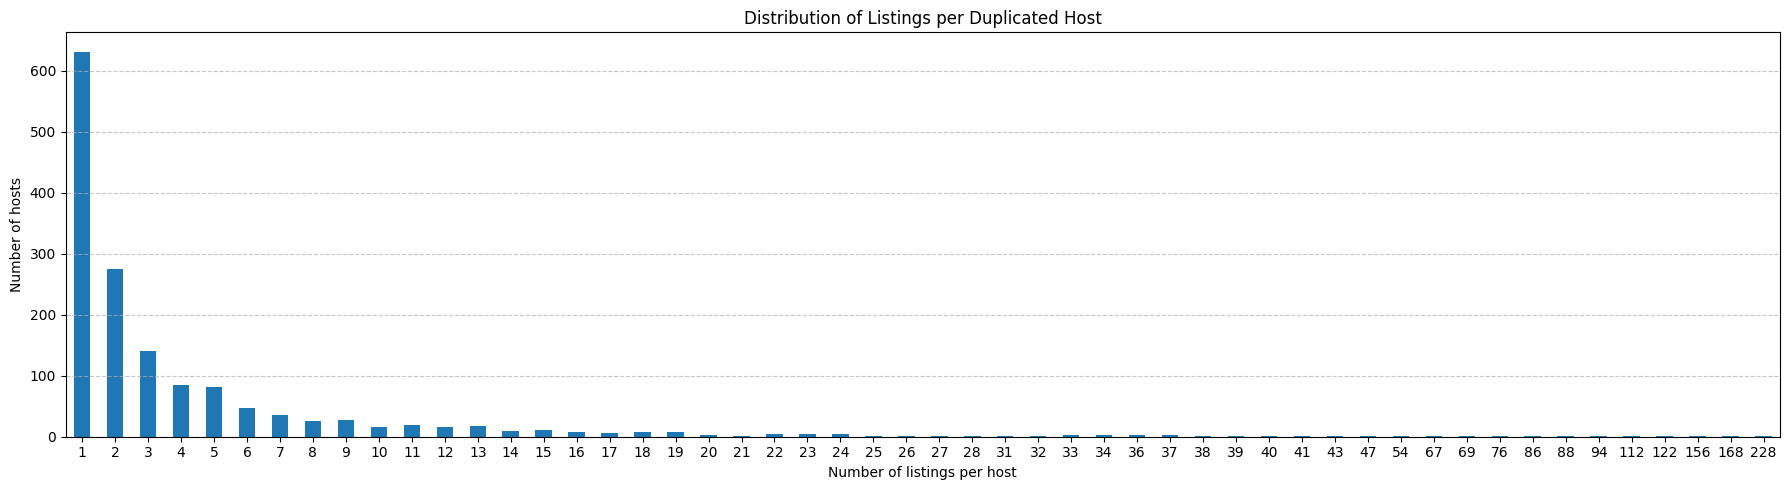

In [29]:
# Count occurrences of each duplicated host_id (including all duplicates)
duplicate_counts = bcn_filt_bnb[bcn_filt_bnb.duplicated(subset=['host_id'])]
host_id_counts = duplicate_counts['host_id'].value_counts()

# Count how many hosts have each number of listings
counts_of_counts = host_id_counts.value_counts().sort_index()

# Plot
plt.figure(figsize=(18, 5))
counts_of_counts.plot(kind='bar')
plt.xlabel('Number of listings per host')
plt.ylabel('Number of hosts')
plt.title('Distribution of Listings per Duplicated Host')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

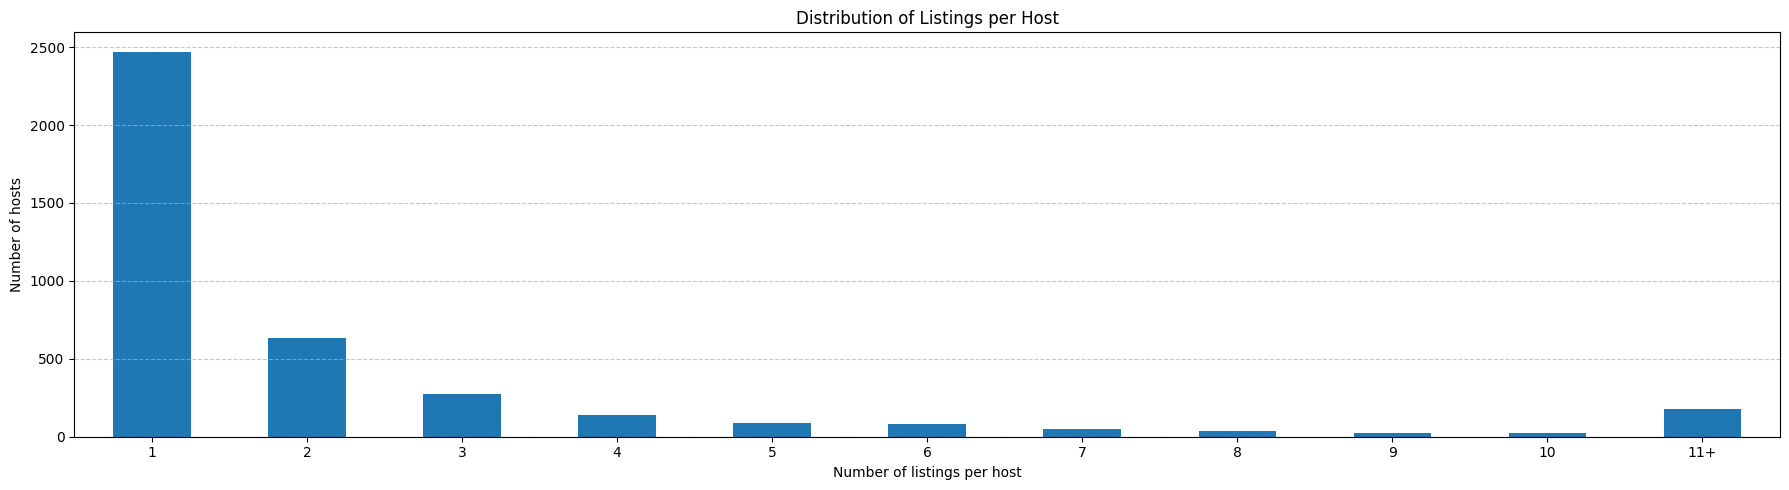

In [30]:
# Count all occurrences of host_id (including those with only one listing)
host_id_counts = bcn_filt_bnb['host_id'].value_counts()

# Cap host listings above 20 into '21+'
capped_counts = host_id_counts.apply(lambda x: x if x <= 10 else 11)

# Count how many hosts have each number of listings (with 21+ grouped)
counts_of_counts = capped_counts.value_counts().sort_index()

# Rename 21 to '21+'
counts_of_counts.index = counts_of_counts.index.map(lambda x: str(x) if x <= 10 else '11+')

# Plot
plt.figure(figsize=(18, 5))
counts_of_counts.plot(kind='bar')
plt.xlabel('Number of listings per host')
plt.ylabel('Number of hosts')
plt.title('Distribution of Listings per Host')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [31]:
# Check if the sum of host_id_counts matches the total number of rows
sum_host_id_counts = counts_of_counts.sum()
print(f"Sum of host_id_counts: {sum_host_id_counts}")

Sum of host_id_counts: 3999


In [32]:
bcn_bnb['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

<Figure size 1800x500 with 0 Axes>

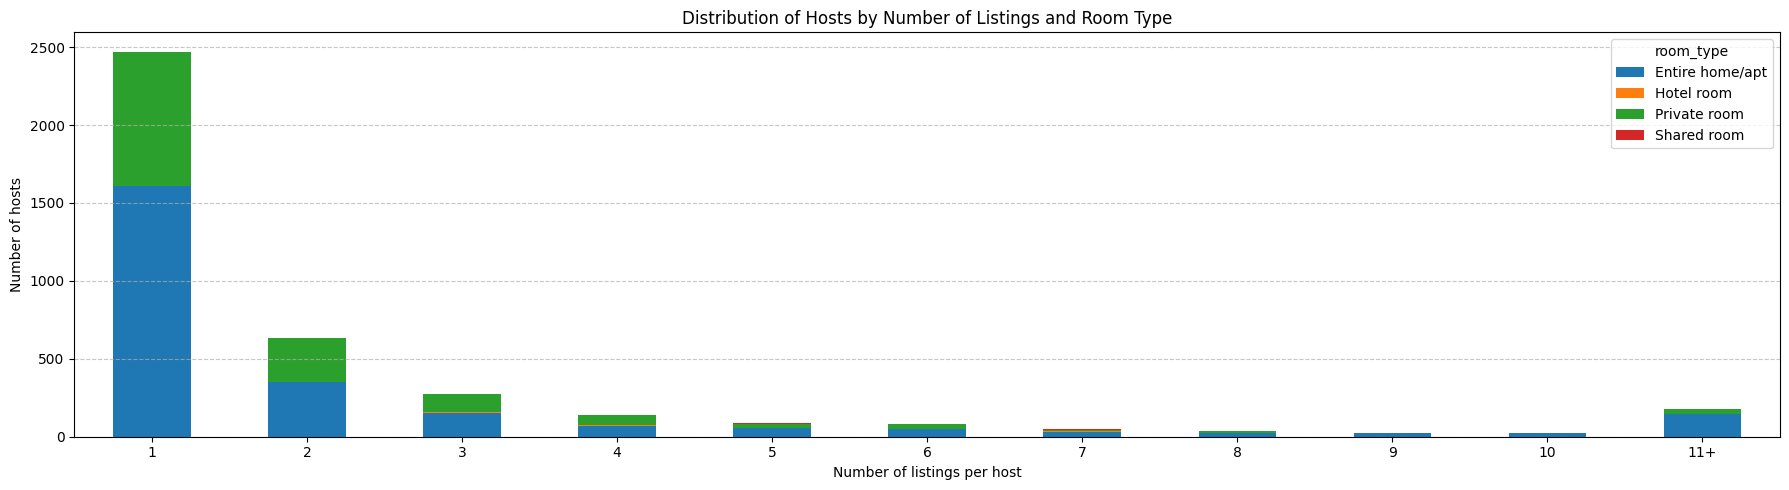

In [33]:
# Step 1: Count listings per host
host_listing_counts = bcn_filt_bnb['host_id'].value_counts()

# Step 2: Most common room_type per host
most_common_room_type = (
    bcn_filt_bnb.groupby(['host_id', 'room_type'])
    .size()
    .unstack(fill_value=0)
    .idxmax(axis=1)
)

# Step 3: Cap listing counts at 11+
capped_counts = host_listing_counts.apply(lambda x: x if x <= 10 else 11)

# Step 4: Create DataFrame with host_id, capped_count, and most_common_room_type
host_summary = pd.DataFrame({
    'capped_count': capped_counts,
    'room_type': most_common_room_type
})

# Step 5: Group by capped listing count and room_type
stack_data = host_summary.groupby(['capped_count', 'room_type']).size().unstack(fill_value=0).sort_index()

# Step 6: Rename 11 to '11+'
stack_data.index = stack_data.index.map(lambda x: str(x) if x <= 10 else '11+')

# Step 7: Plot
plt.figure(figsize=(18, 5))
stack_data.plot(kind='bar', stacked=True, figsize=(18, 5))

plt.xlabel('Number of listings per host')
plt.ylabel('Number of hosts')
plt.title('Distribution of Hosts by Number of Listings and Room Type')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [34]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.transform import dodge
from bokeh.palettes import Category10
from bokeh.models import ColumnDataSource

output_notebook()  # Use this if working in a Jupyter notebook

# Step 1–4: Same data prep as before
host_listing_counts = bcn_filt_bnb['host_id'].value_counts()
most_common_room_type = (
    bcn_filt_bnb.groupby(['host_id', 'room_type'])
    .size()
    .unstack(fill_value=0)
    .idxmax(axis=1)
)
capped_counts = host_listing_counts.apply(lambda x: x if x <= 10 else 11)
host_summary = pd.DataFrame({
    'capped_count': capped_counts,
    'room_type': most_common_room_type
})
stack_data = host_summary.groupby(['capped_count', 'room_type']).size().unstack(fill_value=0).sort_index()
stack_data.index = stack_data.index.map(lambda x: str(x) if int(x) <= 10 else '11+')

# Step 5: Prepare data for Bokeh
x = stack_data.index.tolist()
room_types = stack_data.columns.tolist()

source = ColumnDataSource(data=dict(x=x, **{rt: stack_data[rt].tolist() for rt in room_types}))

# Step 6: Create plot
p = figure(x_range=x, height=400, width=900, title="Distribution of Hosts by Number of Listings and Room Type",
           toolbar_location=None, tools="")

colors = Category10[len(room_types)]

p.vbar_stack(room_types, x='x', width=0.9, color=colors, source=source,
             legend_label=room_types)

# Step 7: Style
p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_right"
p.legend.orientation = "horizontal"
p.xaxis.axis_label = "Number of listings per host"
p.yaxis.axis_label = "Number of hosts"

show(p)

Loading BokehJS ...

In [42]:
df = bcn_filt_bnb.copy()

In [43]:
# Count listings per host and room type
host_counts = df.groupby(['host_id', 'room_type']).size().reset_index(name='count')
host_total = host_counts.groupby('host_id')['count'].sum().reset_index(name='total_listings')
host_counts = pd.merge(host_counts, host_total, on='host_id')
host_counts['listing_bin'] = host_counts['total_listings'].apply(lambda x: str(x) if x <= 10 else '11+')

# Prepare data for stacked bar chart
room_types = df['room_type'].unique()
listing_bins = sorted(host_counts['listing_bin'].unique(), key=lambda x: int(x) if x.isdigit() else 11)

# Create pivot table
pivot_data = {rt: [] for rt in room_types}
for b in listing_bins:
    subset = host_counts[host_counts['listing_bin'] == b]
    for rt in room_types:
        pivot_data[rt].append(subset[subset['room_type'] == rt].shape[0])

pivot_data['listing_bin'] = listing_bins
source = ColumnDataSource(data=pivot_data)

# Create the figure
p = figure(x_range=listing_bins, height=400, title="Listings per Host by Room Type",
           toolbar_location=None, tools="")

colors = Category10[len(room_types)]
renderers = []
legend_items = []

# Add stacked bars
for i, rt in enumerate(room_types):
    r = p.vbar(x='listing_bin', top=rt, width=0.9, source=source, color=colors[i], legend_label=rt)
    renderers.append(r)

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

output_notebook()
show(p)

Loading BokehJS ...

In [35]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, CheckboxGroup, CustomJS
from bokeh.layouts import column, row
from bokeh.palettes import Category10

output_notebook()

# Step 1–4: Same data prep
host_listing_counts = bcn_filt_bnb['host_id'].value_counts()
most_common_room_type = (
    bcn_filt_bnb.groupby(['host_id', 'room_type'])
    .size()
    .unstack(fill_value=0)
    .idxmax(axis=1)
)
capped_counts = host_listing_counts.apply(lambda x: x if x <= 10 else 11)
host_summary = pd.DataFrame({
    'capped_count': capped_counts,
    'room_type': most_common_room_type
})
stack_data = host_summary.groupby(['capped_count', 'room_type']).size().unstack(fill_value=0).sort_index()
stack_data.index = stack_data.index.map(lambda x: str(x) if int(x) <= 10 else '11+')

# Step 5: Prepare data
x = stack_data.index.tolist()
room_types = stack_data.columns.tolist()
colors = Category10[max(3, len(room_types))]

source = ColumnDataSource(data=dict(x=x, **{rt: stack_data[rt].tolist() for rt in room_types}))

# Step 6: Create base figure
p = figure(x_range=x, height=400, width=900, title="Distribution of Hosts by Number of Listings and Room Type",
           toolbar_location=None, tools="")

renderers = []
for i, rt in enumerate(room_types):
    r = p.vbar(x='x', top=rt, width=0.9, source=source, color=colors[i % len(colors)], legend_label=rt, name=rt)
    renderers.append(r)

# Step 7: Add CheckboxGroup
checkbox = CheckboxGroup(labels=room_types, active=list(range(len(room_types))))

# Step 8: CustomJS to toggle visibility
callback = CustomJS(args=dict(renderers=renderers, checkbox=checkbox), code="""
    for (let i = 0; i < renderers.length; i++) {
        renderers[i].visible = checkbox.active.includes(i);
    }
""")
checkbox.js_on_change('active', callback)

# Final layout
p.legend.visible = False
p.xaxis.axis_label = "Number of listings per host"
p.yaxis.axis_label = "Number of hosts"
p.y_range.start = 0

show(column(checkbox, p))

Loading BokehJS ...

In [40]:
lis = mad_filt_bnb['host_location']
print(lis)

4                    Madrid, Spain
7                    Madrid, Spain
10                   Madrid, Spain
12       California, United States
14                   Madrid, Spain
                   ...            
25172                Madrid, Spain
25179                          NaN
25231            Alcobendas, Spain
25238                Madrid, Spain
25279                          NaN
Name: host_location, Length: 16796, dtype: object


In [18]:
locs = mall_filt_bnb['host_location'].unique()
#print(locs)
mall_filt_bnb['host_location'] = mall_filt_bnb['host_location'].apply(
    lambda x: 'Barcelona' if isinstance(x, str) and 'barcelona' in x.lower() else 'Other'
)
print(mall_filt_bnb['host_location'].unique())


['Other' 'Barcelona']


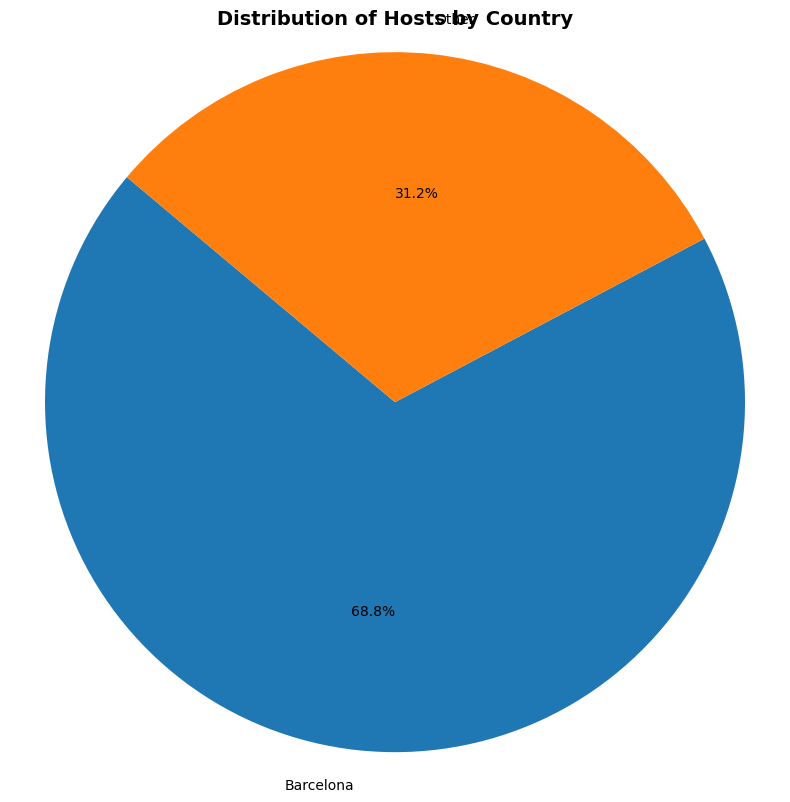

In [33]:
# Count the number of listings per location
location_counts = bcn_bnb['host_location'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(location_counts, labels=location_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Hosts by Country", fontsize=14, weight='bold')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.tight_layout()
plt.show()

In [67]:
bcn_bnb['host_location'].unique()

array(['Barcelona, Spain', 'Catalonia, Spain', 'Spain', 'Colon, Panama',
       "L'Hospitalet de l'Infant, Spain", 'Paiporta, Spain', nan,
       'Sabadell, Spain', 'Tossa de Mar, Spain',
       'Vilanova i la Geltrú, Spain', 'Amsterdam, Netherlands', 'France',
       'Premià de Mar, Spain', 'Hamburg, Germany', 'Girona, Spain',
       'Teià, Spain', 'Linyola, Spain', 'La Garriga, Spain',
       'Premià de Dalt, Spain', 'Viladecans, Spain', 'Tarragona, Spain',
       'London, United Kingdom', 'Cabrils, Spain', 'Castelldefels, Spain',
       'Sitges, Spain', 'Porto, Portugal', 'Badalona, Spain',
       'Hospitalet de Llobregat, Spain', 'Montesson, France',
       'Mueang Chon Buri, Thailand', 'Sant Celoni, Spain',
       'Stockholm, Sweden', 'Caldes de Montbui, Spain',
       'San Francisco, CA', 'Arenys de Mar, Spain', 'Terrassa, Spain',
       'St Pol de Mar, Spain', 'Sant Andreu de Llavaneres, Spain',
       'Altafulla, Spain', 'Genoa, Italy',
       'Sant Vicenç de Montalt, Spain', '

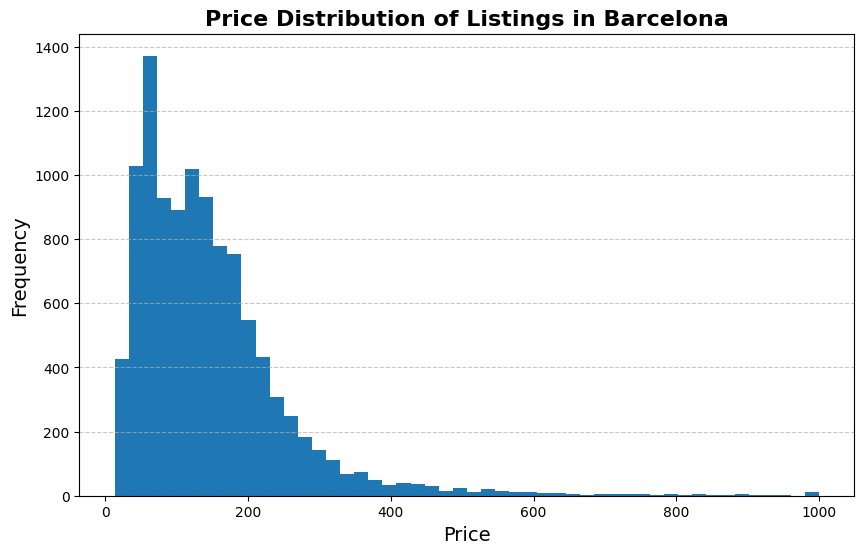

In [45]:
# convert price to int
bcn_filt_bnb['price'] = bcn_filt_bnb['price'].replace('[\$,]', '', regex=True).astype(float)
# remove price > 2000
bcn_filt_bnb = bcn_filt_bnb[bcn_filt_bnb['price'] <= 1000]
plt.figure(figsize=(10, 6))
plt.hist(bcn_filt_bnb['price'], bins=50)
plt.title('Price Distribution of Listings in Barcelona', fontsize=16, weight='bold')
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()